In [2]:
import time
import itertools
import pandas as pd
import numpy as np
from itertools  import product
from joblib import Parallel,delayed
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 三指数平滑
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   # 单指数平滑
from statsmodels.tsa.holtwinters import Holt                 # 双指数平滑
from statsmodels.tsa.statespace.sarimax import SARIMAX       # 季节性自回归综合移动平均SARIMA
from sklearn import metrics
from warnings import catch_warnings,filterwarnings   # catch_warnings暂时禁止警告，filterwarnings在警告过滤器中插入一条数据项。默认情况下，该数据项将被插到前面；

import datetime
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
import seaborn as sns
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
# from statsmodels.stats.diagnostic import unitroot_adf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 全文忽略警告
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns',None)    # 显示所有列
pd.set_option('display.max_row',None)        # 显示所有行
pd.set_option('display.max_colwidth',1000)   # 打印不换行

# 一、导入数据和数据处理

In [4]:
# 数据导入和数据处理
all_data = pd.read_csv('./num_predict.csv')
all_data = all_data[~(all_data['numbers']==1)]
all_data['year'] = all_data['date'].map(lambda x: x.split('-')[0])
all_data['mon_day'] = all_data['date'].map(lambda x: x[5:])

# 保证每年的数据在相同的时间段内
everYear_min_date, everYear_max_date = [], []
for k in all_data['year'].unique():
    i_data = all_data[all_data['year']==k]
    everYear_min_date.append(min(i_data['mon_day']))
    everYear_max_date.append(max(i_data['mon_day']))
all_data = all_data[(all_data['mon_day']>=max(everYear_min_date)) & (all_data['mon_day']<=min(everYear_max_date))]
all_data.set_index('date',inplace=True)

# all_data.rename({'numbers': 'y'},axis='columns',inplace=True)
# all_data.insert(all_data.shape[1], 'store_code', 1)

print(all_data.shape)
all_data.head()

(192, 3)


,numbers,year,mon_day
date,,,
2016-09-06,22.0,2016,09-06
2016-09-07,26.0,2016,09-07
2016-09-08,29.0,2016,09-08
2016-09-09,24.0,2016,09-09
2016-09-10,35.0,2016,09-10


In [35]:
# 2016-2020的数据
data_2016_2020 = list(all_data[~(all_data['year']=='2021')]['numbers'].values)
data_2d_2016_2020 = all_data[~(all_data['year']=='2021')]
# 2021的数据
data_2021 = list(all_data[all_data['year']=='2021']['numbers'].values)
# 全部数据
all_data_list = list(all_data['numbers'].values)

In [36]:
data_2d_2016_2020

,numbers,year,mon_day
date,,,
2016-09-06,22.0,2016,09-06
2016-09-07,26.0,2016,09-07
2016-09-08,29.0,2016,09-08
2016-09-09,24.0,2016,09-09
2016-09-10,35.0,2016,09-10
2016-09-11,49.0,2016,09-11
2016-09-12,53.0,2016,09-12
2016-09-13,54.0,2016,09-13
2016-09-14,47.0,2016,09-14


# 二、数据分析

## 2.1、判断数据是否平稳

In [23]:
#数据平稳性检测 因为只有平稳数据才能做时间序列分析————原理待研究
def judge_stationarity(data_sanya_one):
    dftest = ts.adfuller(data_sanya_one)
    print(dftest)
    stationarity = 1
    for key, value in dftest[4].items():
        if dftest[0] > value:
                stationarity = 0
    # 若ADF值同时小于critical-value中1%，5%，10%对应的值，则说明数据平稳。
    print("是否平稳(1/0): %d" %(stationarity))

stationarity = judge_stationarity(data_2016_2020)

(-5.804427549973745, 4.551368138028973e-07, 0, 159, {'1%': -3.472161410886292, '5%': -2.8798954259680936, '10%': -2.5765565828092245}, 1150.3699019251258)
是否平稳(1/0): 1


In [ ]:
### 数据不平稳则进行差分处理 ###

# 对数据差分
# diff1 = timeseries.diff(1).dropna()  # 1阶差分
# 再进行平稳性判断
# adftest_diff1 = adfuller(diff1,autolag = 'AIC')

## 若1阶差分不能使数据平稳，则继续2阶差分，以此类推（也可以在一阶差分的基础上再进行一阶差分）
# diff2 = timeseries.diff(2).dropna()  # 1阶差分
# 再进行平稳性判断
# adftest_diff2 = adfuller(diff2,autolag = 'AIC')

## 2.2、季节性分析

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose
components = seasonal_decompose(data_2d_2016_2020['numbers'], model='multiplicative')
components.plot()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

test: p=0.0


<Figure size 1080x504 with 0 Axes>

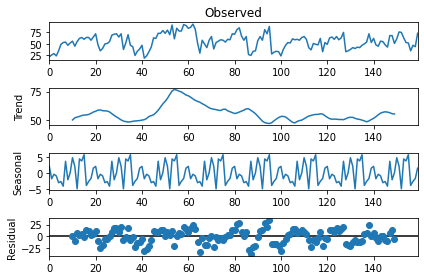

In [44]:
#季节性分解
decomposition = seasonal_decompose(data_2016_2020,freq=20)
plt.figure(figsize=[15, 7])
decomposition.plot()
print("test: p={}".format(ts.adfuller(seasonal)[1]))


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


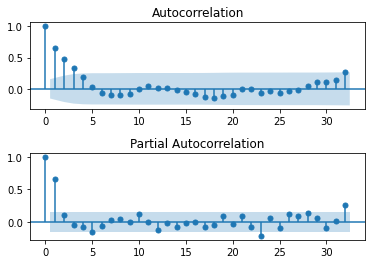

In [12]:
# 画ACF和PACF图，以确定p、q

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
 
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)  #lags 表示滞后的阶数，值为30，显示30阶的图像
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)  
    plt.subplots_adjust(hspace=0.5)
    plt.show()
    
draw_acf_pacf(data_2016_2020,32)

ACF图中，自第三阶之后，数值基本落在2倍标准差范围内，所以q值应选择3

PACF图中，自第一阶之后，数值基本落在2倍标准差范围内，所以p值应选择1

In [105]:
# 根据BIC值选择p，q（BIC越小，参数越合适）

from statsmodels.tsa.arima_model import ARIMA 
 
pmax = int(5)    #一般阶数不超过 length /10
qmax = int(5)
bic_matrix = []
for p in range(pmax +1):
    temp= []
    for q in range(qmax+1):
        try:
            temp.append(ARIMA(all_data_list, (p, 0, q)).fit().bic)
        except:
            temp.append(None)
        bic_matrix.append(temp)

bic_matrix1 = pd.DataFrame(bic_matrix)   # 将其转换成Dataframe 数据结构
p,q = bic_matrix1.stack().idxmin()       # 先使用stack 展平， 然后使用 idxmin 找出最小值的位置
print(u'BIC 最小的p值 和 q 值：%s,%s' %(p,q))  #  BIC 最小的p值 和 q 值：6,1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15380D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      9      1     0     0   0.000D+00   4.154D+00
  F =   4.1538020844461530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85724D+00    |proj g|=  6.26508D-03

At iterate    5    f=  3.85706D+00    |proj g|=  1.51217D-03

At iterate   10    f=  3.85693D+00    |proj g|=  3.35421D-04

At iterate   15    f=  3.85693D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     18      1     0     0   8.882D-08   3.857D+00
  F =   3.8569298000725847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86524D+00    |proj g|=  1.14390D-02

At iterate    5    f=  3.86485D+00    |proj g|=  2.25557D-03

At iterate   10    f=  3.86451D+00    |proj g|=  3.02469D-04

At iterate   15    f=  3.86451D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   1.332D-07   3.865D+00
  F =   3.8645054783515995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86228D+00    |proj g|=  1.10247D-02

At iterate    5    f=  3.86161D+00    |proj g|=  3.32001D-03

At iterate   10    f=  3.86152D+00    |proj g|=  2.22151D-03

At iterate   15    f=  3.86132D+00    |proj g|=  6.99885D-05

At iterate   20    f=  3.86132D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     29      1     0     0   8.882D-08   3.861D+00
  F =   3.8613216298675934     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85952D+00    |proj g|=  1.11175D-02

At iterate    5    f=  3.85634D+00    |proj g|=  1.44672D-02

At iterate   10    f=  3.85421D+00    |proj g|=  5.76250D-04

At iterate   15    f=  3.85407D+00    |proj g|=  4.51061D-03

At iterate   20    f=  3.85400D+00    |proj g|=  2.79776D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     24      1     0     0   4.441D-08   3.854D+00
  F =   3.8539968483410263     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.86621D+00    |proj g|=  9.87939D-03

At iterate    5    f=  3.86575D+00    |proj g|=  1.93863D-03

At iterate   10    f=  3.86533D+00    |proj g|=  2.52109D-04

At iterate   15    f=  3.86533D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     26      1     0     0   4.441D-08   3.865D+00
  F =   3.8653285956064796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85760D+00    |proj g|=  1.69582D-02

At iterate    5    f=  3.85675D+00    |proj g|=  8.22009D-04

At iterate   10    f=  3.85648D+00    |proj g|=  8.76899D-04

At iterate   15    f=  3.85643D+00    |proj g|=  8.65974D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   4.441D-08   3.856D+00
  F =   3.8564348938949617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85149D+00    |proj g|=  1.83429D-02

At iterate    5    f=  3.85085D+00    |proj g|=  4.84608D-03

At iterate   10    f=  3.85073D+00    |proj g|=  8.12861D-04

At iterate   15    f=  3.85063D+00    |proj g|=  8.95284D-05

At iterate   20    f=  3.85063D+00    |proj g|=  4.44089D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     27      1     0     0   4.441D-08   3.851D+00
  F =   3.8506340648017896     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85361D+00    |proj g|=  1.59530D-02

At iterate    5    f=  3.85262D+00    |proj g|=  2.87179D-03

At iterate   10    f=  3.84982D+00    |proj g|=  1.31022D-02

At iterate   15    f=  3.84666D+00    |proj g|=  2.61515D-03

At iterate   20    f=  3.84571D+00    |proj g|=  7.97025D-03

At iterate   25    f=  3.84538D+00    |proj g|=  1.88742D-03

At iterate   30    f=  3.84532D+00    |proj g|=  8.29559D-05

At iterate   35    f=  3.84532D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.86018D+00    |proj g|=  1.97042D-04

At iterate   15    f=  3.86018D+00    |proj g|=  5.41212D-04

At iterate   20    f=  3.86018D+00    |proj g|=  1.42109D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   8.882D-08   3.860D+00
  F =   3.8601780704468207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84436D+00    |proj g|=  4.18467D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84488D+00    |proj g|=  1.16334D-01

At iterate    5    f=  3.84380D+00    |proj g|=  1.67375D-02

At iterate   10    f=  3.84341D+00    |proj g|=  4.73213D-03

At iterate   15    f=  3.84328D+00    |proj g|=  2.27853D-03

At iterate   20    f=  3.84323D+00    |proj g|=  6.36922D-03

At iterate   25    f=  3.84310D+00    |proj g|=  1.22969D-02

At iterate   30    f=  3.84283D+00    |proj g|=  1.86970D-03

At iterate   35    f=  3.84283D+00    |proj g|=  1.12799D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84494D+00    |proj g|=  1.12125D-01

At iterate    5    f=  3.84392D+00    |proj g|=  2.26695D-02

At iterate   10    f=  3.84342D+00    |proj g|=  8.22480D-03

At iterate   15    f=  3.84312D+00    |proj g|=  1.33973D-03

At iterate   20    f=  3.84309D+00    |proj g|=  4.39071D-03

At iterate   25    f=  3.84296D+00    |proj g|=  1.73213D-03

At iterate   30    f=  3.84269D+00    |proj g|=  2.80238D-03

At iterate   35    f=  3.84265D+00    |proj g|=  1.02518D-03

At iterate   40    f=  3.84265D+00    |proj g|=  8.75744D-05

At iterate   45    f=  3.84265D+00    |proj g|=  1.59872D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85971D+00    |proj g|=  1.91275D-02

At iterate    5    f=  3.85849D+00    |proj g|=  5.46656D-03

At iterate   10    f=  3.85785D+00    |proj g|=  6.56453D-04

At iterate   15    f=  3.85772D+00    |proj g|=  3.92228D-03

At iterate   20    f=  3.85764D+00    |proj g|=  6.21725D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   4.441D-08   3.858D+00
  F =   3.8576421241492511     

CONVERG

 This problem is unconstrained.



At iterate   50    f=  3.84141D+00    |proj g|=  5.32907D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   5.329D-06   3.841D+00
  F =   3.8414145615053719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84327D+00    |proj g|=  3.48225D-02

At iterate    5    f=  3.84261D+00    |proj g|=  3.30371D-03

At iterate   10    f=  3.84223D+00    |proj g|=  2.38507D-03

At iter

 This problem is unconstrained.



At iterate   50    f=  3.83990D+00    |proj g|=  6.45528D-04

At iterate   55    f=  3.83988D+00    |proj g|=  9.62164D-04

At iterate   60    f=  3.83987D+00    |proj g|=  4.92895D-04

At iterate   65    f=  3.83986D+00    |proj g|=  1.46514D-03

At iterate   70    f=  3.83985D+00    |proj g|=  6.65468D-04

At iterate   75    f=  3.83985D+00    |proj g|=  8.29337D-04

At iterate   80    f=  3.83985D+00    |proj g|=  1.67821D-04

At iterate   85    f=  3.83984D+00    |proj g|=  4.99867D-04

At iterate   90    f=  3.83984D+00    |proj g|=  1.46541D-03

At iterate   95    f=  3.83984D+00    |proj g|=  1.77058D-04

At iterate  100    f=  3.83984D+00    |proj g|=  1.42553D-04

At iterate  105    f=  3.83984D+00    |proj g|=  2.82530D-04

At iterate  110    f=  3.83983D+00    |proj g|=  1.40998D-04

At iterate  115    f=  3.83983D+00    |proj g|=  1.91802D-04

At iterate  120    f=  3.83983D+00    |proj g|=  3.94351D-05

At iterate  125    f=  3.83983D+00    |proj g|=  1.62004D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85002D+00    |proj g|=  1.99631D-02

At iterate    5    f=  3.84921D+00    |proj g|=  3.84222D-03

At iterate   10    f=  3.84893D+00    |proj g|=  3.77796D-03

At iterate   15    f=  3.84606D+00    |proj g|=  1.89790D-02

At iterate   20    f=  3.84202D+00    |proj g|=  1.50948D-02

At iterate   25    f=  3.84151D+00    |proj g|=  8.35421D-04

At iterate   30    f=  3.84121D+00    |proj g|=  2.43925D-03

At iterate   35    f=  3.84113D+00    |proj g|=  4.78861D-04

At iterate   40    f=  3.84112D+00    |proj g|=  4.47642D-05

At iterate   45    f=  3.84112D+00    |proj g|=  6.45883D-04

At iterate   50    f=  3.84104D+00    |proj g|=  7.65130D-03

At iterate   55    f=  3.84067D+00    |proj g|=  1.35978D-02

At iterate   60    f=  3.84000D+00    |proj g|=  1.31982D-02

At iterate   65    f=  3.8


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85300D+00    |proj g|=  4.89630D-02

At iterate    5    f=  3.84904D+00    |proj g|=  1.37738D-02

At iterate   10    f=  3.84807D+00    |proj g|=  2.65756D-02

At iterate   15    f=  3.84779D+00    |proj g|=  1.82566D-02


 This problem is unconstrained.



At iterate   20    f=  3.84738D+00    |proj g|=  5.51363D-03

At iterate   25    f=  3.84584D+00    |proj g|=  2.70023D-02

At iterate   30    f=  3.84175D+00    |proj g|=  3.55701D-02

At iterate   35    f=  3.84023D+00    |proj g|=  1.13205D-02

At iterate   40    f=  3.84004D+00    |proj g|=  2.45102D-03

At iterate   45    f=  3.83996D+00    |proj g|=  6.43841D-04

At iterate   50    f=  3.83993D+00    |proj g|=  1.03805D-02

At iterate   55    f=  3.83986D+00    |proj g|=  2.98073D-04

At iterate   60    f=  3.83986D+00    |proj g|=  5.36904D-05

At iterate   65    f=  3.83986D+00    |proj g|=  1.55431D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85556D+00    |proj g|=  1.67469D-02

At iterate    5    f=  3.85458D+00    |proj g|=  1.11209D-03

At iterate   10    f=  3.85413D+00    |proj g|=  2.96696D-04

At iterate   15    f=  3.85413D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     19      1     0     0   1.332D-07   3.854D+00
  F =   3.8541310193723426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85119D+00    |proj g|=  1.97228D-02

At iterate    5    f=  3.85018D+00    |proj g|=  6.16076D-03

At iterate   10    f=  3.84458D+00    |proj g|=  3.09866D-02

At iterate   15    f=  3.84166D+00    |proj g|=  3.23093D-03

At iterate   20    f=  3.84145D+00    |proj g|=  7.49969D-03

At iterate   25    f=  3.84131D+00    |proj g|=  3.35865D-04

At iterate   30    f=  3.84130D+00    |proj g|=  4.75620D-05

At iterate   35    f=  3.84130D+00    |proj g|=  2.96208D-04

At iterate   40    f=  3.84130D+00    |proj g|=  6.92779D-06

At iterate   45    f=  3.84130D+00    |proj g|=  7.10543D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.85361D+00    |proj g|=  2.39802D-01

At iterate    5    f=  3.84581D+00    |proj g|=  3.30201D-02

At iterate   10    f=  3.84258D+00    |proj g|=  2.66764D-02

At iterate   15    f=  3.84236D+00    |proj g|=  1.94154D-02

At iterate   20    f=  3.84232D+00    |proj g|=  1.08114D-03

At iterate   25    f=  3.84224D+00    |proj g|=  4.00919D-03

At iterate   30    f=  3.84162D+00    |proj g|=  5.96820D-03

At iterate   35    f=  3.84149D+00    |proj g|=  5.94627D-03

At iterate   40    f=  3.84142D+00    |proj g|=  9.95692D-04

At iterate   45    f=  3.84084D+00    |proj g|=  4.25651D-02

At iterate   50    f=  3.84017D+00    |proj g|=  7.63891D-03

At iterate   55    f=  3.84009D+00    |proj g|=  7.36611D-04

At iterate   60    f=  3.84006D+00    |proj g|=  1.67084D-03

At iterate   65    f=  3.8

 This problem is unconstrained.



At iterate   35    f=  3.83369D+00    |proj g|=  1.10503D-02

At iterate   40    f=  3.83367D+00    |proj g|=  1.27329D-03

At iterate   45    f=  3.83367D+00    |proj g|=  6.70486D-04

At iterate   50    f=  3.83365D+00    |proj g|=  2.11791D-03

At iterate   55    f=  3.83359D+00    |proj g|=  4.81517D-03

At iterate   60    f=  3.83358D+00    |proj g|=  1.64047D-04

At iterate   65    f=  3.83358D+00    |proj g|=  1.81188D-05

At iterate   70    f=  3.83358D+00    |proj g|=  1.59872D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     71     87      1     0     0   1.554D-06   3.834D+00
  F =   3.83358305981

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84581D+00    |proj g|=  5.04627D-01

At iterate    5    f=  3.83762D+00    |proj g|=  2.93626D-02

At iterate   10    f=  3.83478D+00    |proj g|=  2.94647D-02

At iterate   15    f=  3.83244D+00    |proj g|=  4.51168D-03

At iterate   20    f=  3.83242D+00    |proj g|=  1.15566D-02

At iterate   25    f=  3.83220D+00    |proj g|=  1.23609D-02

At iterate   30    f=  3.83210D+00    |proj g|=  1.40673D-02

At iterate   35    f=  3.83207D+00    |proj g|=  4.33706D-03

At iterate   40    f=  3.83204D+00    |proj g|=  7.00964D-03

At iterate   45    f=  3.83202D+00    |proj g|=  2.49596D-03

At iterate   50    f=  3.83201D+00    |proj g|=  5.05196D-03

At iterate   55    f=  3.83200D+00    |proj g|=  2.91536D-03

At iterate   60    f=  3.83200D+00    |proj g|=  3.73213D-04

At iterate   65    f=  3.8

In [68]:
# 通过网格搜索对seasonal_order进行定阶,目前就是pdq=611，seasonal_order=2, 2, 1, 52效果比较好，RMSE=202.4582
# x(2, 2, 2, 32)12 - AIC: 486.94939498219276
# x(2, 2, 3, 32)12 - AIC: 244.19566876431344
# x(2, 3, 3, 32)12 - AIC: 26.0 pbq(6,1,1)
# x(3, 3, 3, 32)12 - AIC: 28.0
# x(2, 3, 3, 32)12 - AIC: 20.0 pbq(1,0,3)

# 参数选择待确认


def get_ARIMA_params(data, pdq, m=12):
    p = d = q = range(0, 3)
    seasonal_pdq = [(x[0], x[1], x[2], m) for x in list(itertools.product(p, d, q))]
    score_aic = 1000000.0
    warnings.filterwarnings("ignore") # specify to ignore warning messages
    for param_seasonal in seasonal_pdq:
        mod = sm.tsa.statespace.SARIMAX(data,
                                        order=pdq,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
        results = mod.fit()
        print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
        if results.aic < score_aic:
            score_aic = results.aic
            params = param_seasonal, results.aic
    param_seasonal, results.aic = params
    print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))
pdq = [1, 0, 3]
get_ARIMA_params(all_data_list, pdq, m=5)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83917D+00    |proj g|=  7.13862D-02

At iterate    5    f=  3.83783D+00    |proj g|=  2.21128D-01

At iterate   10    f=  3.83551D+00    |proj g|=  3.20844D-03

At iterate   15    f=  3.83549D+00    |proj g|=  8.55910D-03

At iterate   20    f=  3.83536D+00    |proj g|=  4.98950D-03

At iterate   25    f=  3.83536D+00    |proj g|=  3.85451D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  3.72854D+00    |proj g|=  4.32221D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     32      1     0     0   8.422D-05   3.729D+00
  F =   3.7285391199488154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 0, 1, 5)12 - AIC:1443.7590220603452
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76643D+00    |proj g|=  6.17471D-01


 This problem is unconstrained.



At iterate    5    f=  3.64528D+00    |proj g|=  1.14936D-01

At iterate   10    f=  3.63484D+00    |proj g|=  2.61535D-02

At iterate   15    f=  3.63398D+00    |proj g|=  2.86171D-03

At iterate   20    f=  3.63390D+00    |proj g|=  1.49412D-02

At iterate   25    f=  3.63387D+00    |proj g|=  2.92951D-03

At iterate   30    f=  3.63387D+00    |proj g|=  2.96045D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     34      1     0     0   2.412D-05   3.634D+00
  F =   3.6338681353419857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 0, 2, 5)12 - AIC:1409.4053639713225
RUNNING TH

 This problem is unconstrained.


x(0, 1, 0, 5)12 - AIC:1529.7309455565262
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75987D+00    |proj g|=  1.57671D-01

At iterate    5    f=  3.71805D+00    |proj g|=  6.06161D-02

At iterate   10    f=  3.64626D+00    |proj g|=  5.97558D-02

At iterate   15    f=  3.62038D+00    |proj g|=  4.09494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     26      1     0     0   4.101D-05   3.620D+00
  F =   3.6203652315175119     

CONVERGENCE: REL_REDUCTION_O

 This problem is unconstrained.


x(0, 1, 1, 5)12 - AIC:1402.2202489027245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65425D+00    |proj g|=  1.62172D-01

At iterate    5    f=  3.61758D+00    |proj g|=  5.38740D-02

At iterate   10    f=  3.58967D+00    |proj g|=  1.01113D-01


 This problem is unconstrained.



At iterate   15    f=  3.54054D+00    |proj g|=  1.31523D-01

At iterate   20    f=  3.52979D+00    |proj g|=  3.68633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   3.269D-05   3.530D+00
  F =   3.5297774775022859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 1, 2, 5)12 - AIC:1369.4345513608778
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.46021D+00    |proj g|=  1.50874D-01

At iterate    5    f=  4.328

 This problem is unconstrained.


x(0, 2, 0, 5)12 - AIC:1653.3877423323197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12042D+00    |proj g|=  5.81749D-01

At iterate    5    f=  4.06094D+00    |proj g|=  6.95944D-02

At iterate   10    f=  4.04319D+00    |proj g|=  2.91862D-02


 This problem is unconstrained.



At iterate   15    f=  3.94695D+00    |proj g|=  3.13509D-01

At iterate   20    f=  3.81104D+00    |proj g|=  2.17350D-02

At iterate   25    f=  3.81081D+00    |proj g|=  1.98365D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     37      1     0     0   2.628D-06   3.811D+00
  F =   3.8108088435565843     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(0, 2, 1, 5)12 - AIC:1475.3505959257284
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.956

 This problem is unconstrained.



At iterate   10    f=  3.89381D+00    |proj g|=  2.40221D-02

At iterate   15    f=  3.83310D+00    |proj g|=  5.03651D-01

At iterate   20    f=  3.52454D+00    |proj g|=  8.43253D-01

At iterate   25    f=  3.50898D+00    |proj g|=  3.26289D-02

At iterate   30    f=  3.50696D+00    |proj g|=  5.05155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     48      1     0     0   3.076D-04   3.507D+00
  F =   3.5069548185140853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(0, 2, 2, 5)12 - AIC:1360.6706503094088
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.73952D+00    |proj g|=  4.23073D-02

At iterate   15    f=  3.73691D+00    |proj g|=  1.06916D-01

At iterate   20    f=  3.73638D+00    |proj g|=  5.57047D-02

At iterate   25    f=  3.73074D+00    |proj g|=  1.27412D-01

At iterate   30    f=  3.72872D+00    |proj g|=  1.74515D-02

At iterate   35    f=  3.72852D+00    |proj g|=  1.21364D-04

At iterate   40    f=  3.72852D+00    |proj g|=  3.78738D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     90      2     0     0   1.314D-04   3.729D+00
  F =   3.7285193096481422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(1, 0, 1, 5)12 - AIC:1445.7514149048866
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.76297D+00    |proj g|=  5.46155D-01

At iterate    5    f=  3.67025D+00    |proj g|=  1.29626D+00

At iterate   10    f=  3.64486D+00    |proj g|=  1.43675D-01

At iterate   15    f=  3.638

 This problem is unconstrained.


x(1, 1, 0, 5)12 - AIC:1479.5237824381989
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77995D+00    |proj g|=  1.13092D-01

At iterate    5    f=  3.71646D+00    |proj g|=  4.39503D-02

At iterate   10    f=  3.68171D+00    |proj g|=  2.29373D-01


 This problem is unconstrained.



At iterate   15    f=  3.62093D+00    |proj g|=  1.26775D-02

At iterate   20    f=  3.62039D+00    |proj g|=  5.93288D-03

At iterate   25    f=  3.62017D+00    |proj g|=  5.76136D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     43      1     0     0   2.719D-05   3.620D+00
  F =   3.6201707837584061     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(1, 1, 1, 5)12 - AIC:1404.145580963228
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.6581

 This problem is unconstrained.



At iterate   15    f=  3.52636D+00    |proj g|=  1.87326D-02

At iterate   20    f=  3.52590D+00    |proj g|=  7.97094D-03

At iterate   25    f=  3.52540D+00    |proj g|=  5.41336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   2.522D-05   3.525D+00
  F =   3.5254007808254317     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(1, 1, 2, 5)12 - AIC:1369.7538998369657
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.195

 This problem is unconstrained.



At iterate   20    f=  4.01522D+00    |proj g|=  6.95849D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      1     0     0   3.885D-05   4.015D+00
  F =   4.0152183586998413     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(1, 2, 0, 5)12 - AIC:1553.843849740739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05202D+00    |proj g|=  1.06544D-01

At iterate    5    f=  4.02140D+00    |proj g|=  3.46414D-02


 This problem is unconstrained.



At iterate   10    f=  3.81609D+00    |proj g|=  2.39537D-01

At iterate   15    f=  3.71517D+00    |proj g|=  4.03985D-02

At iterate   20    f=  3.70963D+00    |proj g|=  3.27721D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     31      1     0     0   1.544D-05   3.710D+00
  F =   3.7096334313683692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(1, 2, 1, 5)12 - AIC:1438.4992376454538
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.003

 This problem is unconstrained.



At iterate   10    f=  3.86721D+00    |proj g|=  5.07395D-02

At iterate   15    f=  3.85379D+00    |proj g|=  1.54774D-01

At iterate   20    f=  3.75146D+00    |proj g|=  1.58770D-01

At iterate   25    f=  3.53138D+00    |proj g|=  1.48108D-01

At iterate   30    f=  3.50855D+00    |proj g|=  1.58737D-01

At iterate   35    f=  3.50692D+00    |proj g|=  1.28489D-02

At iterate   40    f=  3.50688D+00    |proj g|=  1.02278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     42     57      1     0     0   3.252D-05   3.507D+00
  F =   3.5068831718918392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


x(2, 0, 0, 5)12 - AIC:1431.1110103362403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87753D+00    |proj g|=  6.32764D-01

At iterate    5    f=  3.72231D+00    |proj g|=  2.48760D-01

At iterate   10    f=  3.69589D+00    |proj g|=  1.19969D-01

At iterate   15    f=  3.69381D+00    |proj g|=  5.50897D-02

At iterate   20    f=  3.69324D+00    |proj g|=  1.45405D-02

At iterate   25    f=  3.69033D+00    |proj g|=  1.51737D-02


 This problem is unconstrained.



At iterate   30    f=  3.69024D+00    |proj g|=  3.90005D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     41      1     0     0   7.880D-05   3.690D+00
  F =   3.6902437507067298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(2, 0, 1, 5)12 - AIC:1433.0536002713843
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77270D+00    |proj g|=  6.21750D-01

At iterate    5    f=  3.63724D+00    |proj g|=  3.01396D-01

At iterate   10    f=  3.627

 This problem is unconstrained.



At iterate   15    f=  3.62122D+00    |proj g|=  2.18744D-01

At iterate   20    f=  3.62071D+00    |proj g|=  8.20386D-03

At iterate   25    f=  3.61788D+00    |proj g|=  3.45707D-02

At iterate   30    f=  3.61726D+00    |proj g|=  7.37715D-03

At iterate   35    f=  3.61724D+00    |proj g|=  4.22543D-03

At iterate   40    f=  3.61723D+00    |proj g|=  1.13070D-02

At iterate   45    f=  3.61722D+00    |proj g|=  8.13894D-03

At iterate   50    f=  3.61719D+00    |proj g|=  3.09393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   3.094D-03   3.617D+00
  F =   3.61718922643

 This problem is unconstrained.


x(2, 1, 0, 5)12 - AIC:1425.3092289673473
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73258D+00    |proj g|=  1.07237D-01

At iterate    5    f=  3.71362D+00    |proj g|=  6.85914D-02


 This problem is unconstrained.



At iterate   10    f=  3.64456D+00    |proj g|=  2.45410D-02

At iterate   15    f=  3.61955D+00    |proj g|=  8.89270D-02

At iterate   20    f=  3.59335D+00    |proj g|=  3.29644D-02

At iterate   25    f=  3.58333D+00    |proj g|=  3.45619D-02

At iterate   30    f=  3.58217D+00    |proj g|=  5.18219D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     49      1     0     0   7.964D-05   3.582D+00
  F =   3.5821681096016040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(2, 1, 1, 5)12 - AIC:1391.552554087016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-1

 This problem is unconstrained.



At iterate   15    f=  3.53736D+00    |proj g|=  5.59276D-02

At iterate   20    f=  3.52623D+00    |proj g|=  2.51143D-02

At iterate   25    f=  3.52581D+00    |proj g|=  3.91774D-03

At iterate   30    f=  3.52542D+00    |proj g|=  5.92851D-03

At iterate   35    f=  3.52540D+00    |proj g|=  9.63055D-04

At iterate   40    f=  3.52540D+00    |proj g|=  2.83491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     40     43      1     0     0   2.835D-05   3.525D+00
  F =   3.5253978599595222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
x(2, 1, 2, 5)12 - AIC:1371.7527782244565
RUNNING TH

 This problem is unconstrained.



At iterate   15    f=  3.86564D+00    |proj g|=  9.75820D-02

At iterate   20    f=  3.82417D+00    |proj g|=  4.54112D-02

At iterate   25    f=  3.82370D+00    |proj g|=  1.38223D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     32      1     0     0   8.643D-06   3.824D+00
  F =   3.8237011355162949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(2, 2, 0, 5)12 - AIC:1482.3012360382572
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.009

 This problem is unconstrained.



At iterate   10    f=  3.92966D+00    |proj g|=  6.21362D-02

At iterate   15    f=  3.69270D+00    |proj g|=  2.07648D-01

At iterate   20    f=  3.63119D+00    |proj g|=  2.00954D-02

At iterate   25    f=  3.63038D+00    |proj g|=  6.05905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     38      1     0     0   6.730D-06   3.630D+00
  F =   3.6303768288400171     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
x(2, 2, 1, 5)12 - AIC:1410.0647022745666
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 var

 This problem is unconstrained.



At iterate   10    f=  3.79668D+00    |proj g|=  1.39845D-01

At iterate   15    f=  3.74256D+00    |proj g|=  1.08125D+00

At iterate   20    f=  3.70568D+00    |proj g|=  1.78179D-01

At iterate   25    f=  3.61406D+00    |proj g|=  1.01145D+00

At iterate   30    f=  3.53530D+00    |proj g|=  7.29106D-01

At iterate   35    f=  3.51703D+00    |proj g|=  1.56400D-01

At iterate   40    f=  3.51216D+00    |proj g|=  2.33118D-02

At iterate   45    f=  3.50911D+00    |proj g|=  3.87632D-02

At iterate   50    f=  3.50721D+00    |proj g|=  6.60726D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     66   

In [17]:
param_seasonal=(2,2,1,32)
mod = sm.tsa.statespace.SARIMAX(data_2016_2020,
                                order=(1,0,4),
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print('x{}12 - AIC:{}'.format(param_seasonal, results.aic))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53627D-01    |proj g|=  7.89232D-02


 This problem is unconstrained.



At iterate    5    f=  8.30027D-01    |proj g|=  1.51276D-02

At iterate   10    f=  8.25814D-01    |proj g|=  1.90480D-02

At iterate   15    f=  8.23500D-01    |proj g|=  1.62685D-02

At iterate   20    f=  8.13931D-01    |proj g|=  2.27211D-02

At iterate   25    f=  8.01848D-01    |proj g|=  3.43379D-02

At iterate   30    f=  7.99847D-01    |proj g|=  9.32076D-03

At iterate   35    f=  7.89513D-01    |proj g|=  2.33283D-01

At iterate   40    f=  7.86300D-01    |proj g|=  7.62242D-02

At iterate   45    f=  7.83891D-01    |proj g|=  7.86079D-02

At iterate   50    f=  7.83159D-01    |proj g|=  1.99728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [15]:
mod = sm.tsa.statespace.SARIMAX(data_2016_2020,
                                order=(1,0,3),
                                seasonal_order=(2, 3, 3, 32),
                                trend='t',
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [18]:
assess(results.forecast(32))

均方误差MSE: 478.79562004310094
均方根误差RMSE: 21.881398950777825
平均绝对误差MAE: 17.967381099948575
平均绝对百分比误差MAPE: 32.14586528996307
对称平均绝对百分比误差SMAPE: 36.674213649257375


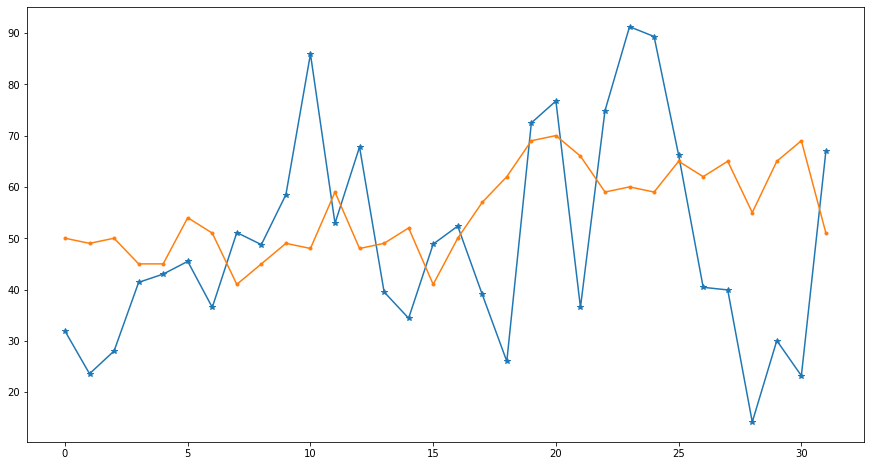

In [19]:
predict_ts = results.predict(tpy='levels')  #tpy='levels'直接预测值，没有的话预测的是差值
plt.figure(figsize=(15, 8))
l3, = plt.plot(results.forecast(32), marker='*')
l4, = plt.plot(all_data_2021, marker='.')
plt.show()


In [ ]:

steps = 32
start_time = myts.index[-1]
forecast_ts = results.forecast(steps)
 
fore = pd.DataFrame()
fore['date'] = pd.date_range(start=start_time ,periods=steps, freq='7D')
fore['result'] = pd.DataFrame(forecast_ts.values)
fore.index = pd.to_datetime(fore['date'])
 
predict_ts['2019/1/18':].plot(color='blue', label='Predict',figsize=(12,8))
myts['2019/1/18':].plot(color='red', label='Original',figsize=(12,8))
fore.result.plot(color='black', label='forecast',figsize=(12,8))
 
plt.legend(loc='best')
plt.show()

In [4]:
# 传入数据和参数，输出模型预测
def model_forecast(history,config):
    order, sorder, trend = config
    model = SARIMAX(history,order=order,seasonal_order=sorder,trend=trend,enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)   # disp如果为True则会打印收敛信息
    # statsmodels.tsa.statespace.sarimax.SARIMAX.fit
    yhat = model_fit.predict(len(history), len(history))   # 获取样本内拟合值的最后一个值
    # statsmodels.tsa.statespace.sarimax.SARIMAXResults.predict
    # 模型结果有四个方法获取值，predict、get_predict、forecast、get_forecast
    # predict(start,end)、get_predict：样本内预测值，拟合值； 其中的参数start和end的意思是：获取拟合值的范围，默认是获取所有拟合值；当然也可以通过设置end来获取样本外预测值
    # forecast(step)、get_forecast：样本外预测值，拟合值； 其中step为预测的周期数，如step=2，则得到接下来两个周期的预测值
    return yhat[0]

In [5]:
#模型评估指标,mape
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100    

#划分训练集和测试集
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]


In [6]:
#one-step滚动向前预测
def forward_valid(data, n_test, cfg):
    predictions = list()   # 得到空列表
    # 调用数据集划分函数train_test_split
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        # 调用预测函数model_forecast
        yhat = model_forecast(history, cfg)
        # 接收预测结果
        predictions.append(yhat)
        # 用测试数据不断扩充训练数据（这里为什么不用预测数据扩充）
        history.append(test[i])
    # 调用评估函数mape，看效果
    error = mape(test, predictions)
    return error


In [7]:
#模型评估
def score_model(data,n_test,cfg,debug=False):
    result = None
    key = str(cfg)
    if debug:
        # 调用滚动预测函数forward_valid
        result = forward_valid(data, n_test, cfg)
    else:
        try:
            # catch_warnings暂时禁止警告，filterwarnings在警告过滤器中插入一条数据项。默认情况下，该数据项将被插到前面；
            with catch_warnings():
                filterwarnings("ignore")
                # 调用滚动预测函数forward_valid
                result = forward_valid(data, n_test, cfg)
        except:
            error = None
            
    return (key, result)


In [8]:
#网格搜索
def grid_search(data, cfg_list, n_test, parallel=True):
    # parallel=True这个参数的意义是：由用户选择是否启用多进程。
    scores = None
    if parallel:
        # 使用计算机全部的cpu核数多进程并行
        # Joblib提供了一个简单的帮助类来编写并行化的循环。其核心思想是把代码写成生成器表达式的样子，然会再将它转换为并行计算
        executor = Parallel(n_jobs=4, backend='multiprocessing')   # 使用所有cpu创建进程池
        # 调用score_model函数，将参数列表中的参数循环，然后与数据一起调用函数
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)   # 调用score_model函数，并传参(data, n_test, cfg)
        # 启动多进程
        scores = executor(tasks)
        ## Parallel(n_jobs=-1)(delayed(score_model)(data, n_test, cfg) for cfg in cfg_list) 也可以一步到位
        
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda x: x[1])   # sort和lambda的联合使用，scores现在是列表，列表内是多个元组，这里针对元组的第二个值进行升序排序
    return scores

#生成参数列表
def sarima_configs(seasonal=[0]):   
    p = d = q = [0,1,2]
    # product(A,B)函数,返回A和B中的元素组成的笛卡尔积的元组,
    pdq = list(product(p, d, q))   
    s = 32
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]
    t=['n','c','t','ct']
    return list(product(pdq,seasonal_pdq,t))

In [9]:
#模型训练
def train_model(sale_df):
    n_test = 3
    p_b,d_b,q_b=[],[],[]
    P_b,D_b,Q_b=[],[],[]
    m_b,t_b=[],[]
    model_id,error=[],[]
    
    data = sale_df['numbers']
    data = [i for i in data]
    # 调用sarima_configs函数————> 返回多个参数多个值的组合列表
    cfg_list = sarima_configs()
    # 调用grid_search函数————> 返回一个列表，列表内是多个元组，元组第一个值是参数组合，第二个值是参数的mape得分，根据得分进行了升序排序，
    scores = grid_search(data,cfg_list,n_test,parallel=False)
#     # 解析出每个分店的最优参数组合，并放入Dataframe中进行返回
#     p_b.append(int(scores[0][0][2]))
#     d_b.append(int(scores[0][0][5]))
#     q_b.append(int(scores[0][0][8]))
#     P_b.append(int(scores[0][0][13]))
#     D_b.append(int(scores[0][0][16]))
#     Q_b.append(int(scores[0][0][19]))
#     m_b.append(int(scores[0][0][22]))
#     t_b.append(str(scores[0][0][27]))
#     model_id.append(i)
#     error.append(scores[1][-1])
#     params_df=pd.DataFrame({'store_code': model_id, 'map': error,'p':p_b,'d':d_b,'q':q_b,'P':P_b,'D':D_b,'Q':Q_b,'m':m_b,'t':t_b})

    return scores

In [ ]:
params_df = train_model(all_data)

In [78]:
params_df

[((0, 0, 0), (0, 0, 0, 32), 'n'),
 ((0, 0, 0), (0, 0, 0, 32), 'c'),
 ((0, 0, 0), (0, 0, 0, 32), 't'),
 ((0, 0, 0), (0, 0, 0, 32), 'ct'),
 ((0, 0, 0), (0, 0, 1, 32), 'n'),
 ((0, 0, 0), (0, 0, 1, 32), 'c'),
 ((0, 0, 0), (0, 0, 1, 32), 't'),
 ((0, 0, 0), (0, 0, 1, 32), 'ct'),
 ((0, 0, 0), (0, 0, 2, 32), 'n'),
 ((0, 0, 0), (0, 0, 2, 32), 'c'),
 ((0, 0, 0), (0, 0, 2, 32), 't'),
 ((0, 0, 0), (0, 0, 2, 32), 'ct'),
 ((0, 0, 0), (0, 1, 0, 32), 'n'),
 ((0, 0, 0), (0, 1, 0, 32), 'c'),
 ((0, 0, 0), (0, 1, 0, 32), 't'),
 ((0, 0, 0), (0, 1, 0, 32), 'ct'),
 ((0, 0, 0), (0, 1, 1, 32), 'n'),
 ((0, 0, 0), (0, 1, 1, 32), 'c'),
 ((0, 0, 0), (0, 1, 1, 32), 't'),
 ((0, 0, 0), (0, 1, 1, 32), 'ct'),
 ((0, 0, 0), (0, 1, 2, 32), 'n'),
 ((0, 0, 0), (0, 1, 2, 32), 'c'),
 ((0, 0, 0), (0, 1, 2, 32), 't'),
 ((0, 0, 0), (0, 1, 2, 32), 'ct'),
 ((0, 0, 0), (0, 2, 0, 32), 'n'),
 ((0, 0, 0), (0, 2, 0, 32), 'c'),
 ((0, 0, 0), (0, 2, 0, 32), 't'),
 ((0, 0, 0), (0, 2, 0, 32), 'ct'),
 ((0, 0, 0), (0, 2, 1, 32), 'n'),
 ((0, 0

In [80]:
all_data['numbers']

date
2016-09-06    22.0
2016-09-07    26.0
2016-09-08    29.0
2016-09-09    24.0
2016-09-10    35.0
2016-09-11    49.0
2016-09-12    53.0
2016-09-13    54.0
2016-09-14    47.0
2016-09-15    52.0
2016-09-16    56.0
2016-09-17    45.0
2016-09-18    55.0
2016-09-19    62.0
2016-09-20    64.0
2016-09-21    60.0
2016-09-22    64.0
2016-09-23    64.0
2016-09-24    58.0
2016-09-25    65.0
2016-09-26    72.0
2016-09-27    48.0
2016-09-28    35.0
2016-09-29    40.0
2016-09-30    50.0
2016-10-01    51.0
2016-10-02    55.0
2016-10-03    69.0
2016-10-04    71.0
2016-10-05    72.0
2016-10-06    65.0
2016-10-07    72.0
2017-09-06    38.0
2017-09-07    52.0
2017-09-08    70.0
2017-09-09    47.0
2017-09-10    44.0
2017-09-11    25.0
2017-09-12    34.0
2017-09-13    39.0
2017-09-14    47.0
2017-09-15    19.0
2017-09-16    24.0
2017-09-17    33.0
2017-09-18    43.0
2017-09-19    63.0
2017-09-20    62.0
2017-09-21    73.0
2017-09-22    73.0
2017-09-23    79.0
2017-09-24    73.0
2017-09-25    80.0
2017-09

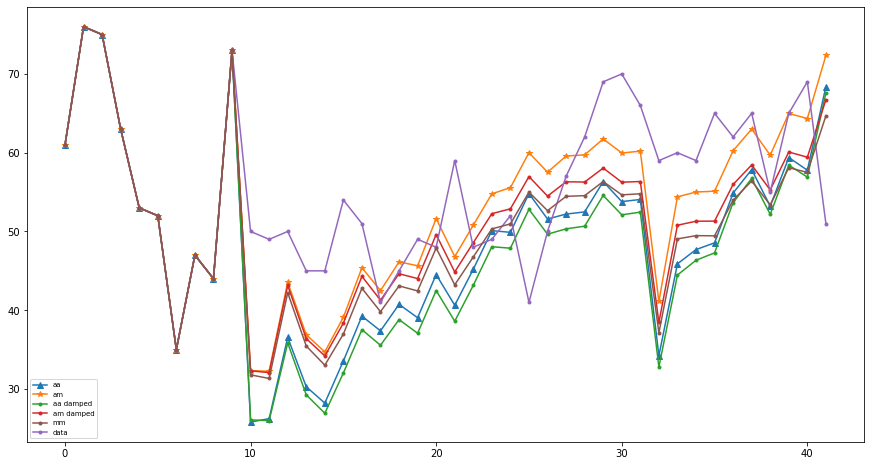

In [36]:
# 三指数平滑预测
fit1 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='add').fit(use_boxcox=True)
fit2 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='mul').fit(use_boxcox=True)
fit3 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
fit4 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
fit5 = ExponentialSmoothing(data_2016_2020, seasonal_periods=32, trend='mul', seasonal='mul', damped=True).fit(use_boxcox=True)

plt.figure(figsize=(15, 8))

l1, = plt.plot(data_2016_2020[150:] + list(fit1.forecast(32)), marker='^')
l2, = plt.plot(data_2016_2020[150:] + list(fit2.forecast(32)), marker='*')
l3, = plt.plot(data_2016_2020[150:] + list(fit3.forecast(32)), marker='.')
l4, = plt.plot(data_2016_2020[150:] + list(fit4.forecast(32)), marker='.')
l6, = plt.plot(data_2016_2020[150:], marker='.')
l5, = plt.plot(data_2016_2020[150:] + list(fit5.forecast(32)), marker='.')

plt.legend(handles = [l1, l2, l3, l4, l5, l6], 
           labels = ["aa", "am", "aa damped", "am damped","mm","data"], 
           loc = 'best', 
           prop={'size': 7})

plt.show()

In [45]:
# 季节性ARIMAX
model = SARIMAX(data_2016_2020, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(data_2016_2020), len(data_2016_2020))

In [46]:
yhat

array([67.26330705])

In [8]:
def mape_fun(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape_fun(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

In [9]:
def assess(predict_data):
    # 均方误差
    mse = metrics.mean_squared_error(all_data_2021, predict_data)
    print('均方误差MSE:', mse)
    # 均方根误差
    rmse = np.sqrt(metrics.mean_squared_error(all_data_2021, predict_data))
    print('均方根误差RMSE:', rmse)
    # 平均绝对误差
    mae = metrics.mean_absolute_error(all_data_2021, predict_data)
    print('平均绝对误差MAE:', mae)
    # 平均绝对百分比误差
    mape = mape_fun(all_data_2021, predict_data)
    print('平均绝对百分比误差MAPE:', mape)
    # 对称平均绝对百分比误差
    smape = smape_fun(all_data_2021, predict_data)
    print('对称平均绝对百分比误差SMAPE:', smape)

In [43]:
for i,v in enumerate([fit1,fit2,fit3,fit4,fit5]):
    print('当前对象：fit%d'%(i+1))
    print(assess(v.forecast(32)))

当前对象：fit1
均方误差MSE: 171.25919051753388
均方根误差RMSE: 13.086603475215938
平均绝对误差MAE: 11.162695988673608
平均绝对百分比误差MAPE: 20.520167251000405
对称平均绝对百分比误差SMAPE: 23.38106400025231
None
当前对象：fit2
均方误差MSE: 89.91457119425814
均方根误差RMSE: 9.482329418147112
平均绝对误差MAE: 7.499230440874235
平均绝对百分比误差MAPE: 14.232660881796342
对称平均绝对百分比误差SMAPE: 14.822870583472048
None
当前对象：fit3
均方误差MSE: 196.147767702533
均方根误差RMSE: 14.005276423638806
平均绝对误差MAE: 12.267402023137986
平均绝对百分比误差MAPE: 22.49086262105206
对称平均绝对百分比误差SMAPE: 25.950846239942294
None
当前对象：fit4
均方误差MSE: 102.2558912283522
均方根误差RMSE: 10.112165506376574
平均绝对误差MAE: 8.272040447268218
平均绝对百分比误差MAPE: 15.083050184505531
对称平均绝对百分比误差SMAPE: 16.30478111968248
None
当前对象：fit5
均方误差MSE: 119.43568802406057
均方根误差RMSE: 10.928663597350802
平均绝对误差MAE: 9.174935792720682
平均绝对百分比误差MAPE: 16.56159659406486
对称平均绝对百分比误差SMAPE: 18.252541579665294
None


In [144]:
fit1 = ExponentialSmoothing(
    all_data_list,
    seasonal_periods=32,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit()

In [145]:
df = pd.DataFrame(
    np.c_[all_data_list, fit1.level, fit1.trend, fit1.season, fit1.fittedvalues],
    columns=[r"$y_t$", r"$l_t$", r"$b_t$", r"$s_t$", r"$\hat{y}_t$"],
    index=all_data.index,
)
df.append(pd.DataFrame(fit1.forecast(10),columns=[r"$\hat{y}_t$"]), sort=True)

,$\hat{y}_t$,$b_t$,$l_t$,$s_t$,$y_t$
2016-09-06,22.658346,-0.013318,40.810661,-18.628499,22.0
2016-09-07,22.347979,-0.013301,43.438851,-18.449350,26.0
2016-09-08,34.131488,-0.013325,39.713943,-9.294081,29.0
2016-09-09,24.067979,-0.013325,39.651449,-15.632640,24.0
2016-09-10,22.196659,-0.013265,48.898785,-17.441418,35.0
2016-09-11,37.615560,-0.013211,57.119890,-11.269918,49.0
2016-09-12,50.188265,-0.013198,59.140408,-6.918403,53.0
2016-09-13,48.902002,-0.013174,62.814594,-10.225189,54.0
2016-09-14,56.089303,-0.013217,56.227123,-6.712150,47.0
2016-09-15,49.014139,-0.013203,58.373581,-7.199757,52.0


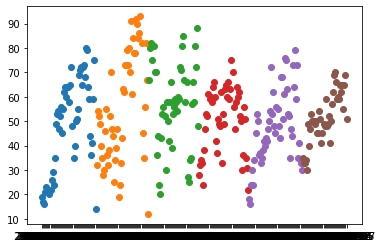

In [47]:
for i in all_data['year'].unique():
    i_data = all_data[all_data['year']==i]
    # display(i_data['numbers'].describe())
    # plt.plot(i_data['date'], i_data['numbers'])
    plt.scatter(i_data['date'], i_data['numbers'])
    # i_data[['date','numbers']]

In [ ]:
# 处理规则
# 1、多数年份最小值偏离较多，可以统一剔除最小值